# [CDAF] Atividade 2

## Nome e matrícula
Nome: João Antonio Oliveira Pedrosa
Matrícula: 2019006752

## Introdução
Nesta atividade, vamos revisar os conceitos aprendidos em sala de aula sobre estatísticas agregadas. Para esta atividade, usaremos dados do Brasileirão 2022 do FBRef.

In [44]:
import pandas as pd
import numpy as np
import json
import matplotlib.pyplot as plt
import statsmodels.api as sm
import statsmodels.formula.api as smf
import os
import pathlib
import warnings
from scipy import stats
from mplsoccer import PyPizza, FontManager

## Questão 1
- Baixe o dataset de resultados em https://fbref.com/en/comps/24/2022/schedule/2022-Serie-A-Scores-and-Fixtures
- Crie uma média móvel de 5 jogos, para cada equipe, de cada uma das seguintes estatísticas: xG pró, xG contra, e dif. xG.
- Escolha 4 times para visualizar a série temporal das estatísticas acima. Uma visualização para cada uma das estatísticas, onde a média geral do campeonato é apresentada com uma linha pontilhada em conjunto com a média móvel dos times escolhidos.
- Interprete os resultados. O que isso pode indicar sobre a qualidade ofensiva e defensiva dos times escolhidos?

In [67]:
df = pd.read_csv("scores.csv")
teams = list(df["Home"].unique())
ev_teams = teams[:4]

Não entendi se eu deveria fazer uma tabela com todas as médias móveis e acredito que nem daria para visualizar muito bem.
Então para o segundo item, criei essa função, que gera a média móvel do time que você passar como parâmetro. Espero que seja suficiente :)

In [77]:
# Retorna 3 listas contendo os valores da média móvel para xG Pró, xG Contra e Dif XG
def mv_average(df, team, step):
    df_t = df[(df["Home"] == "Fluminense") | (df["Away"] == "Fluminense")].copy()
    df_t.reset_index(inplace=True)
    for i in range(len(df_t)):
        # Flipping values (Kinda ugly I know but I want to use df.rolling)
        if(df_t["Home"][i] != team):
            aux = df_t.at[i, "xG"]
            df_t.at[i, "xG"] = df_t.at[i, "xG.1"]
            df_t.at[i, "xG.1"] = aux
            
    df_t = df_t[["xG", "xG.1"]]
    # Moving Average
    df_t_rolled = df_t.rolling(step, min_periods=1).mean()
    pro = list(df_t_rolled["xG"])
    con = list(df_t_rolled["xG.1"])
    
    return pro, con, [pro[i] - con[i] for i in range(len(pro))]

In [111]:
# Cria os gráficos conforme requisitado
def graphs(ev_teams, step, df):
    
    teams_a = dict()
    for team in ev_teams:
        teams_a[team] = mv_average(df, team, step)
    
    for k, v in teams_a.items():
        plt.plot(v[0], label = k) 
    plt.axhline(y = df["xG"].mean(), color = 'r', linestyle = '--')
    plt.title("Gols Pró")
    plt.legend()
    plt.show()
    plt.close()

    for k, v in teams_a.items():
        plt.plot(v[1], label = str(k))
    plt.axhline(y = df["xG.1"].mean(), color = 'r', linestyle = '--')
    plt.title("Gols Contra")
    plt.legend()
    plt.show()
    plt.close()

    for k, v in teams_a.items():
        plt.plot(v[2], label = str(k))
    plt.axhline(y = (df["xG"].sum() - df["xG.1"].sum())/len(df), color = 'r', linestyle = '--')
    plt.title("Diferença de Gols")
    plt.legend()
    plt.show()
    plt.close()

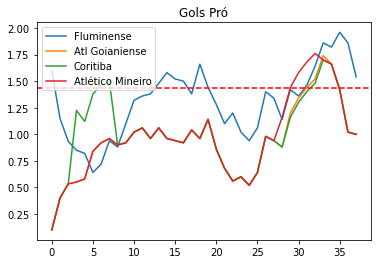

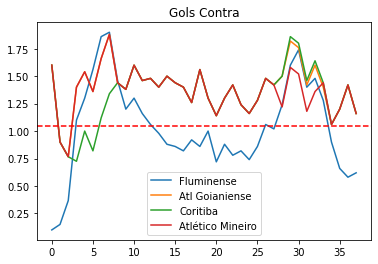

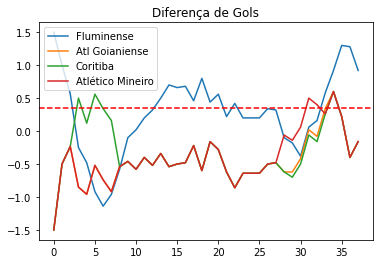

In [112]:
graphs(ev_teams, 5, df)

A quantidade de gols esperados pró pode ser utilizada como uma medida do quão eficiente o ataque de um time está sendo, no sentido de que, quantos mais finalizações com boas chances de gol forem criadas, maior será a quantidade esperada de gols.

Já a medida da quantidade de gols esperados contras pode ser utilizada como medida para avaliar o quão eficiente está sendo a defesa de um time, uma vez que, quanto menos chances o adversário conseguir criar, menor será a quantidade esperada de gols.

Analisemos o Atlético Mineiro, por exemplo. É possível perceber pelo gráfico de diferença de gols que há alguma evidência de que o time teve uma melhora de performance no final do campeonato e, ao avaliar as estatísticas de Gols Pró e Contra, existe também a evidência de que o que melhorou foi a qualidade ofensiva do time, dado que a tendência de gols esperados contra continuou a mesma, porém houve um aumento na quantidade de Gols Esperados Pró, o que significa que o time foi capaz de criar mais chances dentro de jogo.

## Questão 2
- Agora repita a questão 1, plotando as séries temporais dos mesmos times, mas para uma janela móvel de 10 jogos.
- Quais as diferenças entre as séries temporais de 5 e 10 jogos? Em quais situações pode ser vantajoso escolher uma janela à outra?

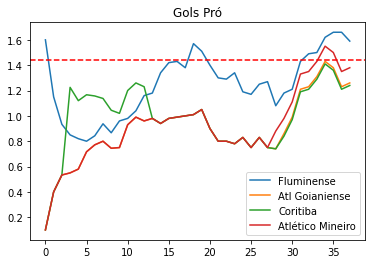

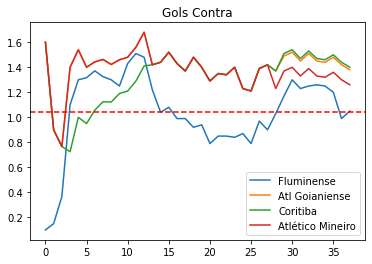

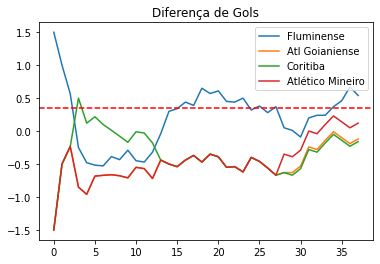

In [113]:
graphs(ev_teams, 10, df)

O módulo da primeira derivada tende a ser menor conforme maior a janela que utilizarmos pois as mudanças serão mais gradativas. Isso inclusive explica por que os valores nas bordas do gráficos são mais distantes da média.

É interessante utilizar janelas maiores quando queremos avaliar a performance dos times através de períodos maiores de tempo, ou seja, quando não queremos que mudanças bruscas impactem tanto nossos gráficos. Se um tiver uma sequência muito boa de 5 jogos e depois voltar a performar mal em algum aspecto, essa sequência poderá ser mais facilmente visualizada no gráfico que utilizou uma janela menor.

Suponhamos, por exemplo, que um novo jogador chega no time na metade da temporada e é titular durante o restante do campeonato. Talvez seja interessante utilizar a análise com os dois tamanhos diferentes de janela. Com um tamanho menor, podemos avaliar se a mudança brusca no time teve algum impacto negativo no curto prazo e com a janela maior podemos avaliar se, no longo prazo, a mudança acabou sendo positiva para o time.

## Questão 3
- Vá para o link
-- https://fbref.com/en/comps/24/2022/stats/2022-Serie-A-Stats
- Nesta seção de estatísticas, é possível navegar por estatísticas específicas para diferentes aspectos do jogo (finalização, passe, defesa, etc.). Para todos exercícios à partir deste, você terá que selecionar aquelas que julgar mais relevantes para responder as questões.
- Monte um radar plot com 6 atributos relevantes para atacantes e compare 3 jogadores de sua escolha. Justifique a escolha de cada um dos atributos, a escolha da escala dos radares e o tipo de normalização. Interprete os resultados dos radares em termos das qualidades e limitações dos jogadores.
- Ref Soccermatics:
-- https://soccermatics.readthedocs.io/en/latest/lesson3/ScoutingPlayers.html
-- https://soccermatics.readthedocs.io/en/latest/gallery/lesson3/plot_RadarPlot.html

Iremos utilizar os seguintes atributos para atacantes.

- Goals (Medida clara para a efetividade do atacante)
- Non-Penalty Goals (Medida clara para a efetividade do atacante)
- Assistências (Medida clara para a efetividade do atacante)
- Expected Goals (Avalia o posicionamento)
- Progressive Carries (Avalia a capacidade do jogador de avançar a bola para o campo adversário)
- Matches Played (Possibilita dimensionar o tamanho do espaço amostral que foi utilizado para fazer o plot)

A normalização será feita dividindo todas as estatísticas pelo número de minutos que o jogador esteve em campo e multiplicando por 90, assim podemos ter uma ideia de qual seria a média por jogo se o jogador jogasse todos os jogos durante os 90 minutos.

In [52]:
df = pd.read_csv("std_stats.csv")

In [57]:
df_per_90 = pd.DataFrame()
df_per_90["Player"] = df["Player"]
df_per_90["MP"] = df["MP"]
for column in df.columns:
    try:
        df_per_90[column + "_per90"] = (df.apply(lambda x: x[column]*90/x["Min"], axis = 1))
    except:
        continue

In [59]:
def plot_radar(player, df_per_90, attributes, names):
    player_df = df_per_90.loc[df_per_90["Player"] == player]
    player_df = player_df[attributes]
    per_90_columns = player_df.columns[:]
    values = [round(player_df[column].iloc[0],2) for column in per_90_columns]
    percentiles = [int(stats.percentileofscore(df_per_90[column], player_df[column].iloc[0])) for column in per_90_columns]
    
    slice_colors = ["red"] * (len(attributes)//2 + len(attributes)%2) + ["blue"] * (len(attributes)//2)
    text_colors = ["white"] * len(attributes)
    font_normal = FontManager(("https://github.com/google/fonts/blob/main/apache/roboto/"
                               "Roboto%5Bwdth,wght%5D.ttf?raw=true"))
    font_bold = FontManager(("https://github.com/google/fonts/blob/main/apache/robotoslab/"
                             "RobotoSlab%5Bwght%5D.ttf?raw=true"))
    #PIZZA PLOT
    baker = PyPizza(
        params=names,
        min_range = None,
        max_range = None,               # list of parameters
        straight_line_color="#000000",  # color for straight lines
        straight_line_lw=1,             # linewidth for straight lines
        last_circle_lw=1,               # linewidth of last circle
        other_circle_lw=1,              # linewidth for other circles
        other_circle_ls="-."            # linestyle for other circles
    )
    #making pizza for our data
    fig, ax = baker.make_pizza(
        percentiles,              # list of values
        figsize=(10, 10),      # adjust figsize according to your need
        param_location=110,
        slice_colors=slice_colors,
        value_colors = text_colors,
        value_bck_colors=slice_colors, # where the parameters will be added
        kwargs_slices=dict(
            facecolor="cornflowerblue", edgecolor="#000000",
            zorder=2, linewidth=1
        ),                   # values to be used when plotting slices
        kwargs_params=dict(
            color="#000000", fontsize=12,
            fontproperties=font_normal.prop, va="center"
        ),                   # values to be used when adding parameter
        kwargs_values=dict(
            color="#000000", fontsize=12,
            fontproperties=font_normal.prop, zorder=3,
            bbox=dict(
                edgecolor="#000000", facecolor="cornflowerblue",
                boxstyle="round,pad=0.2", lw=1
            )
        )                    # values to be used when adding parameter-values
    )

    #putting text
    texts = baker.get_value_texts()
    for i, text in enumerate(texts):
        text.set_text(str(values[i]))
    # add title
    fig.text(
        0.515, 0.97, f"{player} a cada 90 minutos", size=18,
        ha="center", fontproperties=font_bold.prop, color="#000000"
    )

    # add subtitle
    fig.text(
        0.515, 0.942,
        "Campeonato Brasileiro 2022",
        size=15,
        ha="center", fontproperties=font_bold.prop, color="#000000"
    )
    plt.show()

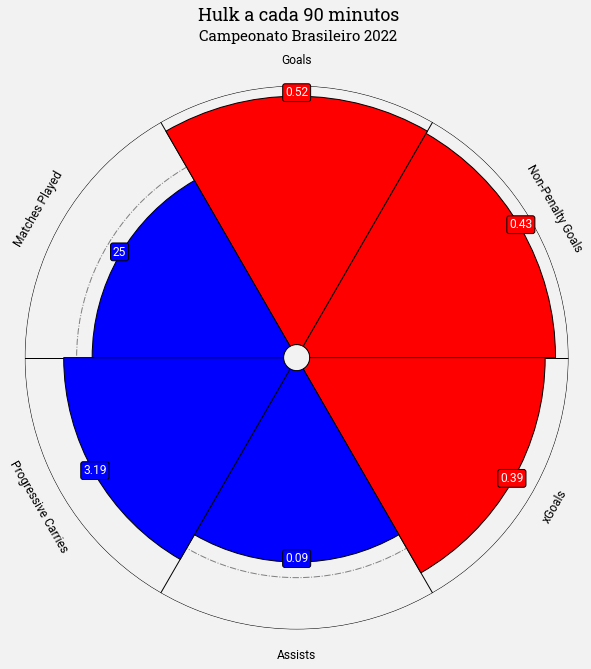

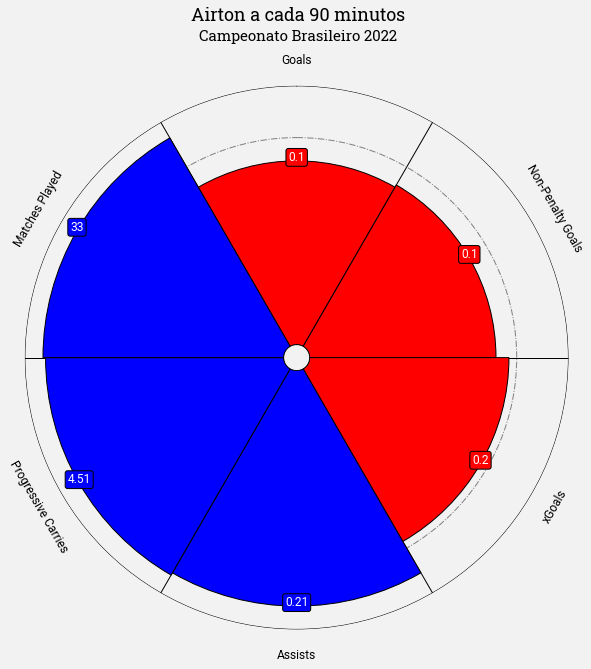

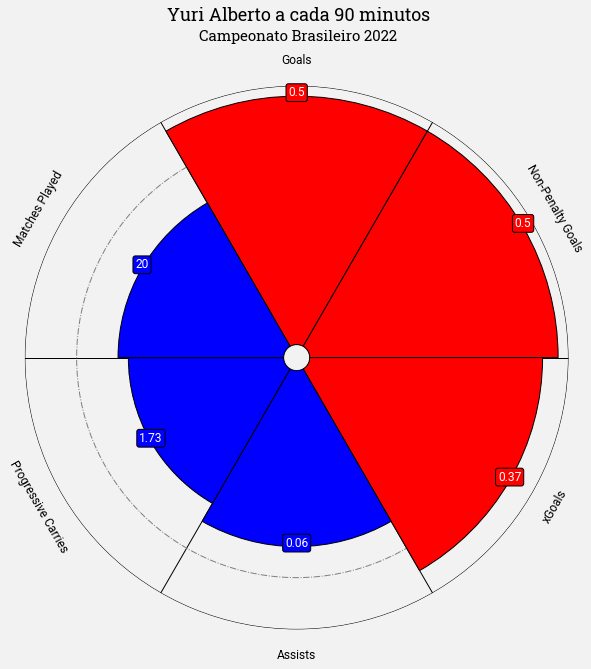

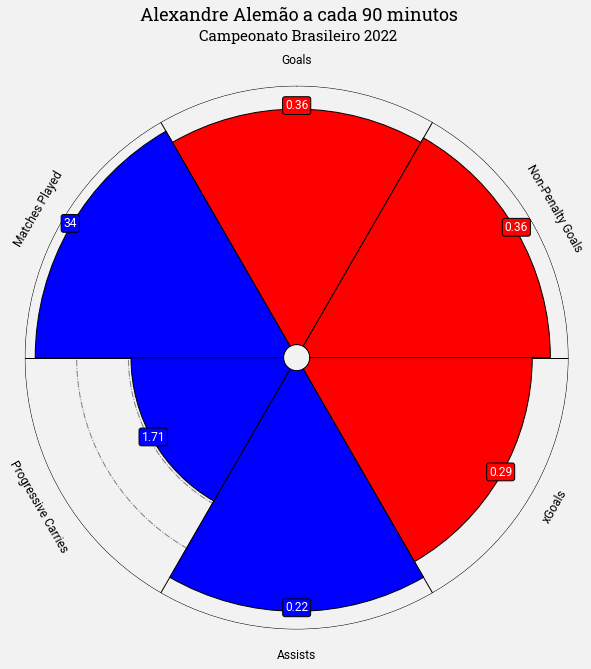

In [62]:
attributes = ["Gls_per90", "G-PK_per90", "xG_per90", "Ast_per90", "PrgC_per90", "MP"]
names = ["Goals", "Non-Penalty Goals", "xGoals", "Assists", "Progressive Carries", "Matches Played"]
players = ["Hulk", "Airton", "Yuri Alberto", "Alexandre Alemão"]
for player in players:
    plot_radar(player, df_per_90, attributes, names)

Por esse gráfico podemos perceber que Hulk e Yuri Alberto atuam mais como marcadores, enquanto Alexandre Alemão e Airton são mais eficazes na assistência, atuando mais como atacantes que também são armadores. Todos os jogadores, com exceção do Airton, tem um número de gols maior do que a quantidade esperada de gols, indicando que são bons finalizadores e costumam aproveitar as chances que tem. O número elevado de passes progressivos no radar do Hulk conduz com o perfil do jogador, que costuma ser o principal inciador de jogadas ofensivas no Galo. 

O radar também desmente as afirmações dos invejosos de que o Hulk só faz gol de penalti :)

## Questão 4
- Faça o mesmo que na questão 3, mas para meio campistas.

Iremos utilizar os seguintes atributos para meio-campistas.

- Goals (Medida clara para a efetividade do meio-campista)
- Assistências (Medida clara para a efetividade do meio-campista)
- Progressive Carries (Avalia a capacidade do jogador de avançar a bola para o campo adversário)
- Progressive Passes
- Progressive Passes Received
- Matches Played (Possibilita dimensionar o tamanho do espaço amostral que foi utilizado para fazer o plot)

A normalização será feita dividindo todas as estatísticas pelo número de minutos que o jogador esteve em campo e multiplicando por 90, assim podemos ter uma ideia de qual seria a média por jogo se o jogador jogasse todos os jogos durante os 90 minutos.

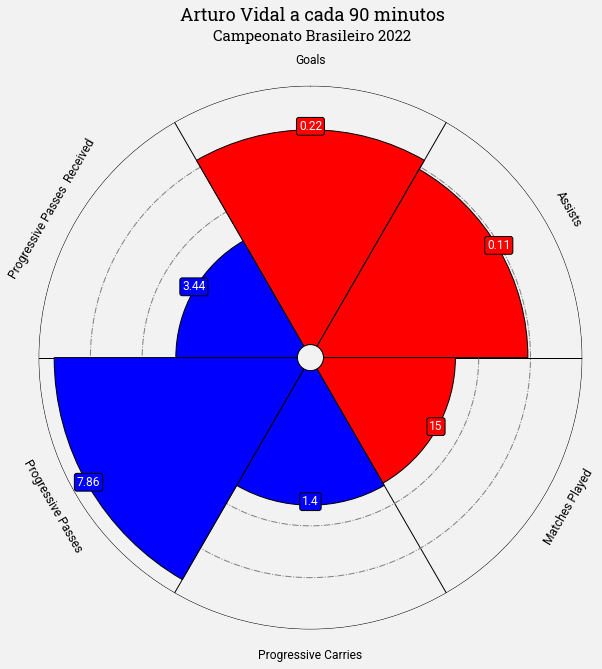

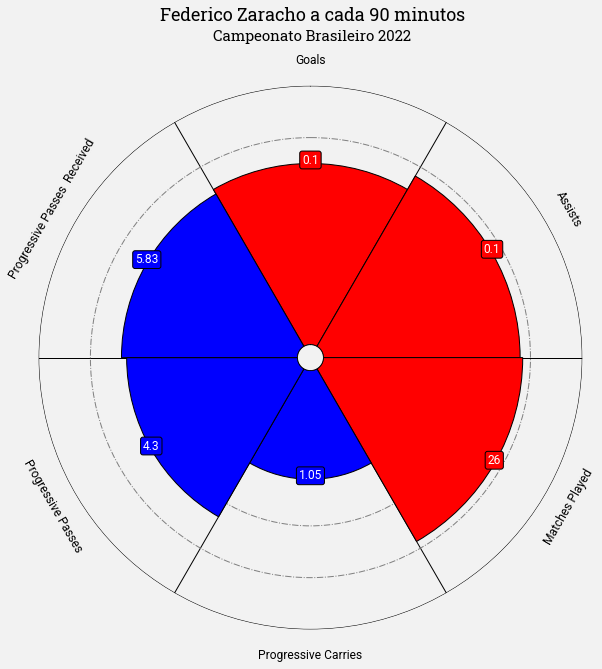

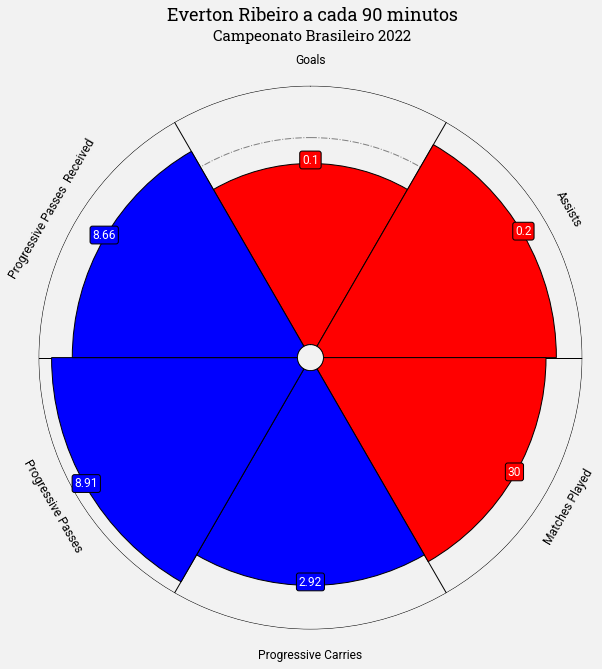

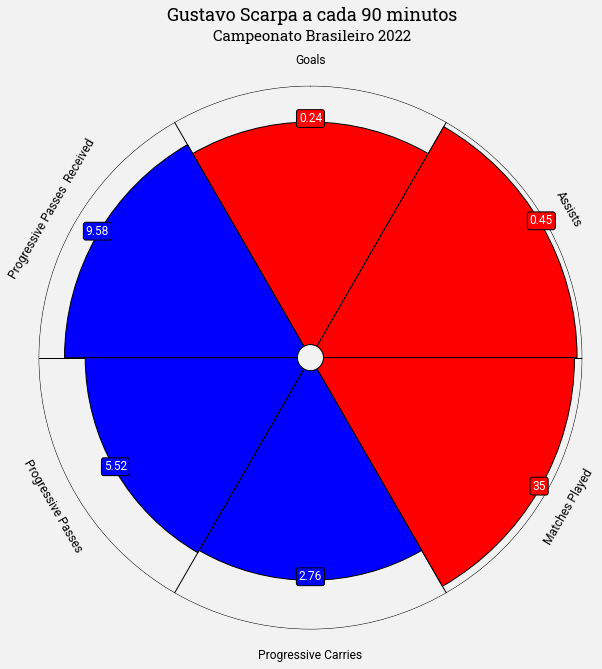

In [64]:
attributes = ["Gls_per90", "Ast_per90", "MP", "PrgC_per90", "PrgP_per90", "PrgR_per90"]
names = ["Goals", "Assists", "Matches Played", "Progressive Carries","Progressive Passes","Progressive Passes  Received", ]
players = ["Arturo Vidal", "Federico Zaracho", "Everton Ribeiro", "Gustavo Scarpa"]
for player in players:
    plot_radar(player, df_per_90, attributes, names)

## Questão 5
- Faça o mesmo que na questão 3, mas para zagueiros.

Iremos utilizar os seguintes atributos para zagueiros.

- Yellow Cards (Analisar cartões nos permite analisar o quão efetivo o jogador está sendo em não cometer faltas graves durante seus desarmes)
- Red Cards
- Progressive Carries (Avalia a capacidade do zagueiro de avançar a bola do campo de defesa para o campo adversário)
- Progressive Passes
- Progressive Passes Received
- Matches Played (Possibilita dimensionar o tamanho do espaço amostral que foi utilizado para fazer o plot)

A normalização será feita dividindo todas as estatísticas pelo número de minutos que o jogador esteve em campo e multiplicando por 90, assim podemos ter uma ideia de qual seria a média por jogo se o jogador jogasse todos os jogos durante os 90 minutos.

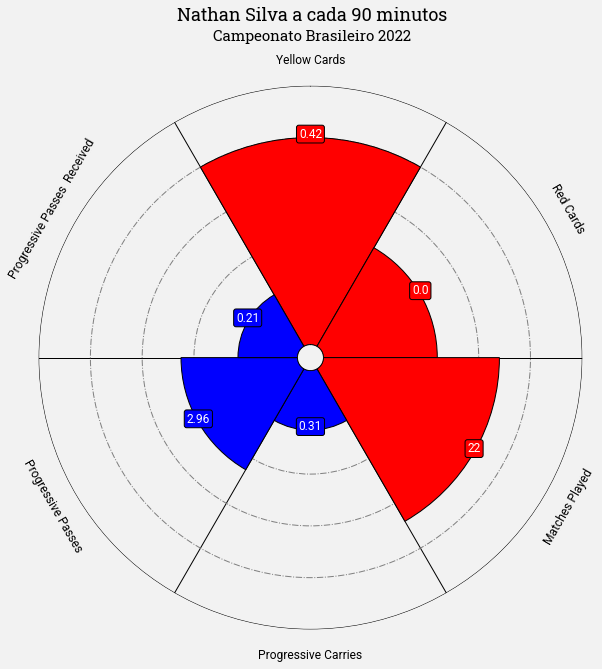

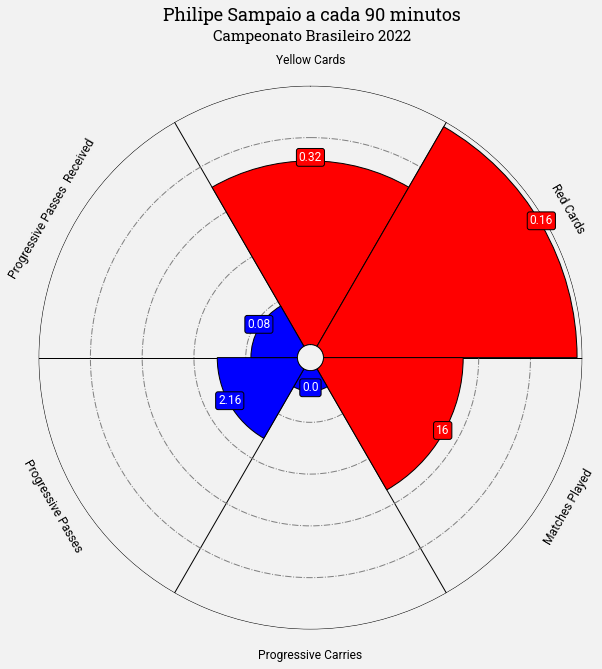

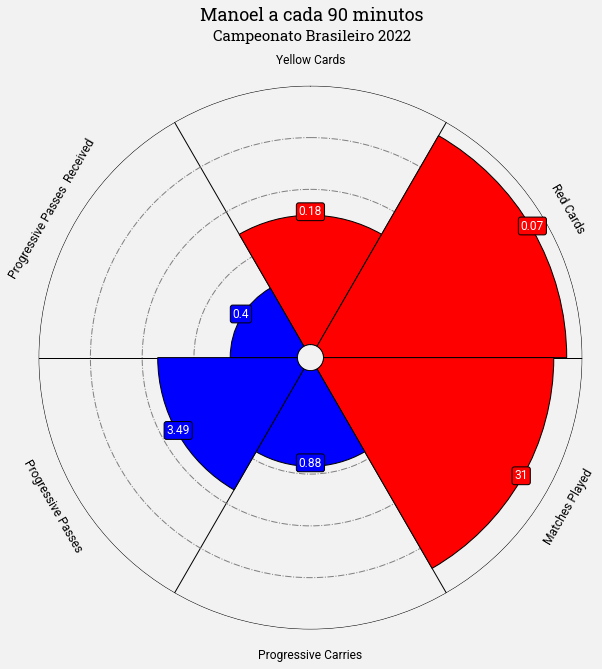

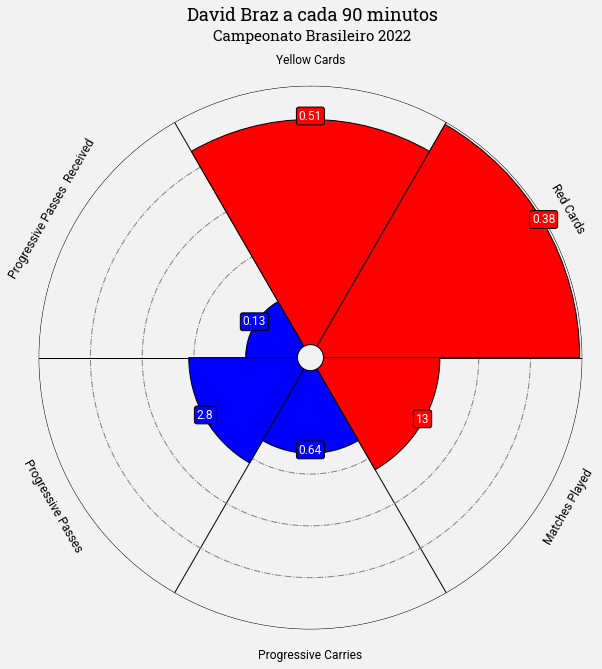

In [66]:
attributes = ["CrdY_per90", "CrdR_per90", "MP", "PrgC_per90", "PrgP_per90", "PrgR_per90"]
names = ["Yellow Cards", "Red Cards", "Matches Played", "Progressive Carries","Progressive Passes","Progressive Passes  Received", ]
players = ["Nathan Silva", "Philipe Sampaio", "Manoel", "David Braz"]
for player in players:
    plot_radar(player, df_per_90, attributes, names)

## Questão 6
- Discuta as diferenças entre os radares das questões 3, 4 e 5. Quais são as principais diferenças entre os atributos relevantes para cada posição? Quais são as principais semelhanças? A impressão subjetiva que você tinha dos jogadores se comprovou pelos radares? Se não, por quê? Quais posições são mais difíceis de serem avaliadas por estatísticas?

Quanto mais defensiva é uma posição mais difícil ela é de ser analisada estatisticamente pois os marcadores de Gols e Assistências são métricas muito fáceis de serem coletadas e são claramente uma boa medida para a efetividade de um jogador ofensivo, já que envolvem diretamente o objetivo do jogo, que é marcar gols. Conforme temos que progredir para usar métricas mais subjetivas, como desarmes, a confiança que podemos ter em nossa análise estatística vai diminuindo.

Meio-Campistas e Atacantes dividem mais atributos entre si do que com Zagueiros. Inclusive, uma das dificuldades que tive ao plotar os gráficos foi decidir quais atributos utilizar para os zagueiros, mas decidi pelos que acredito serem os melhores dentre os que estão na tabela indicada.

A impressão subjetiva dos jogadores se confirmou, Hulk não faz gol só de pênalti :)